<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 15


In [1]:
import sys
sys.path.append("../")

In [2]:

import numpy as np
from pomegranate import *
import seaborn as sns

In [37]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [6]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state

In [7]:
sns.set(color_codes=True)

In [8]:
# change the paths here accordingly 

wga_mean_tuf_I_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_tuf_I_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_TUF_DETAIL_I.txt"

wga_mean_single_copy_deletion_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
no_wga_mean_single_copy_deletion_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_SINGLE_COPY_DELETION.txt"

wga_mean_duplication_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_DUPLICATION.txt"
no_wga_mean_duplication_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_DUPLICATION.txt"

wga_mean_delete_file = "/home/alex/qi3/hidden_markov_modeling/data/wga_windows_mean_0_DELETE.txt"
no_wga_mean_delete_file = "/home/alex/qi3/hidden_markov_modeling/data/no_wga_windows_mean_0_DELETE.txt"

In [9]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)

wga_mu_single_copy_deletion = load_data_file(filename=wga_mean_single_copy_deletion_file)
no_wga_mu_single_copy_deletion = load_data_file(filename=no_wga_mean_single_copy_deletion_file)

wga_mu_duplication = load_data_file(filename=wga_mean_duplication_file)
no_wga_mu_duplication = load_data_file(filename=no_wga_mean_duplication_file)

wga_mu_delete = load_data_file(filename=wga_mean_delete_file)
no_wga_mu_delete = load_data_file(filename=no_wga_mean_delete_file)


In [10]:
# mix the data

# WGA sample
wga_mu = []
wga_mu.extend(wga_mu_single_copy_deletion)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_delete)


# NO-WGA sample
no_wga_mu = []
no_wga_mu.extend(no_wga_mu_single_copy_deletion)
no_wga_mu.extend(no_wga_mu_duplication)
no_wga_mu.extend(no_wga_mu_delete)


## Cluster the reference data

In [11]:
# Dictionay that holds the states for the HMM 
states={}

In [12]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  154276.31931354915
Len of labels:  11741


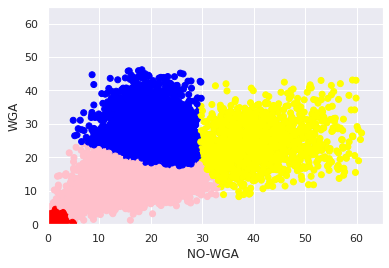

Color-cluster association {'pink': [4, 5741], 'blue': [1, 4137], 'yellow': [3, 1288], 'red': [2, 355], 'green': [0, 220]}


In [13]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=500, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 65.0),
                                                 ylim=(0., 65.0))

print("Color-cluster association", color_comp_assoc)

This depends on the clustering above so we need to make sure that colors do align

In [14]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

INFO: Component 0 means [1.39253543e-20 1.39151675e-20] 
INFO: Component 1 means [19.64165597 23.32612237] 
INFO: Component 2 means [0.95891068 0.97127385] 
INFO: Component 3 means [39.62956133 24.28395967] 
INFO: Component 4 means [16.661641   13.75773901] 


state name:  Duplication
State means:  [39.62956133 24.28395967]
State covariance:  [71.58097989 39.46549823]


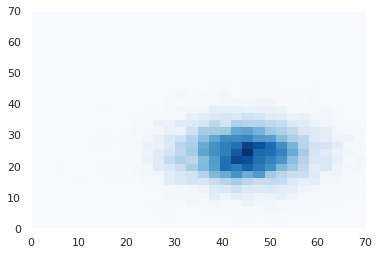

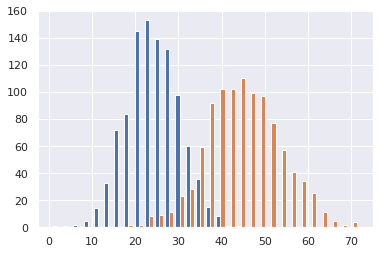

state name:  Normal-I
State means:  [16.661641   13.75773901]
State covariance:  [31.48607526 19.04228589]


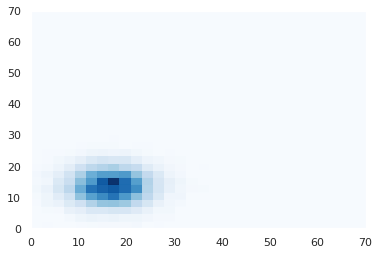

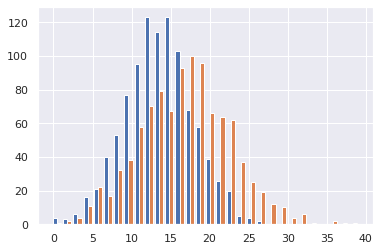

state name:  Normal-II
State means:  [19.64165597 23.32612237]
State covariance:  [19.59454881 52.48696452]


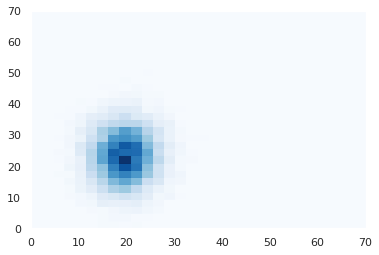

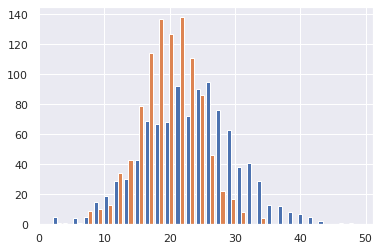

state name:  Deletion
State means:  [0.95891068 0.97127385]
State covariance:  [1.19508059 1.10648874]


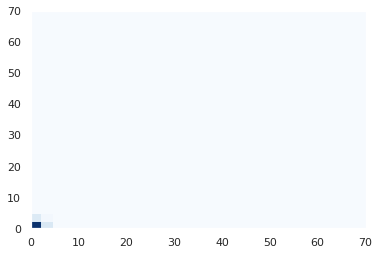

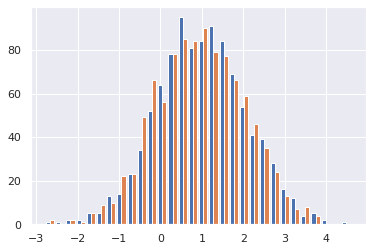

In [15]:
states_map = {"Duplication": 3, "Normal-I": 4, 
              "Normal-II": 1, "Deletion": 2}
states = create_states(states_map=states_map, means=means, covariances=covariances, plot=True)

### Cluster for TUF

Simply use the ref TUF I region to extract the distribution.

In [16]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [17]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  15265.0768774819
Len of labels:  1231


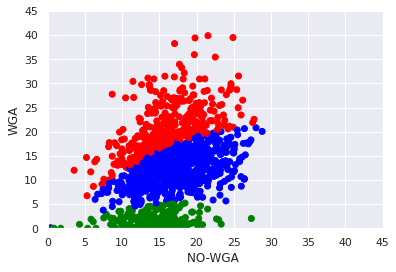

In [18]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=tuf_data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [19]:
print("Color-cluster association for TUF", color_comp_assoc_tuf)

Color-cluster association for TUF {'red': [2, 371], 'blue': [1, 677], 'green': [0, 183]}


In [20]:
tuf_idx = 0

TUF means:  [14.22026929  1.73453063  0.19150384]
TUF covariances:  [1.56558660e+01 1.92606368e+00 1.10283242e-02]


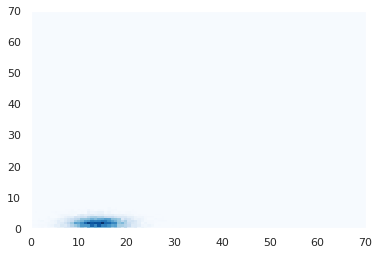

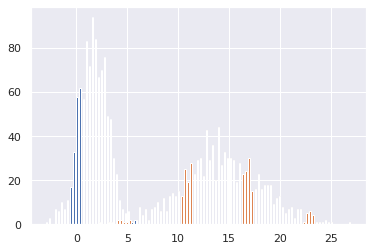

In [21]:
tuf_means = gmm_tuf.means_
tuf_cov = gmm_tuf.covariances_
states['TUF'] = create_tuf_state(tuf_means=tuf_means[tuf_idx], tuf_cov=tuf_cov[tuf_idx])


## Apply HMM

In [22]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]

In [23]:
gap_state = None
gap_state_dist = None


In [26]:
if configuration["remove_windows_with_gaps"] == False:
    
    name="GAP_STATE"
    
    # we have a gap state then add it
    gap_windows_dist = configuration["gap_windows_dist"]
    gap_state_dist = get_dist_list(dists_name=[gap_windows_dist["name"],
                                               gap_windows_dist["name"]],
                                               params={"uniform_params":gap_windows_dist["config"]["parameters"]})

    gap_state = \
            State(IndependentComponentsDistribution(gap_state_dist), 
                  name=name)
    states[name] = gap_state

In [27]:
print("{0} Number of states: {1}".format(INFO, len(states)))
for state in states:
    print(state)

INFO: Number of states: 6
Duplication
Normal-I
Normal-II
Deletion
TUF
GAP_STATE


In [28]:
# print info about the states
for name in states:
    state = states[name]
    print("{0} State: {1}".format(INFO, state.name))
    state_map = json.loads(str(state))
    print("{0} Distributions: {1}".format(INFO,
                                          state_map["distribution"]))

# create the HMM
hmm_model = HiddenMarkovModel(name=hmm_config["name"],
                              start=None, end=None)

states_list = []
for state in states:
    states_list.append(states[state])
hmm_model.add_states(states_list)

INFO: State: Duplication
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.28395966730902, 45.0], [[39.46549823389773, 0.0], [0.0, 71.58097989044529]]], 'frozen': False}
INFO: State: Normal-I
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[13.757739010094747, 16.661641002131116], [[19.04228589445913, 0.0], [0.0, 31.486075256440248]]], 'frozen': False}
INFO: State: Normal-II
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[23.326122369833698, 19.64165597476193], [[52.48696451975172, 0.0], [0.0, 19.594548811024598]]], 'frozen': False}
INFO: State: Deletion
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[0.9712738481062316, 0.9589106769641359], [[1.1064887359059503, 0.0], [0.0, 1.1950805867926322]]], 'frozen': False}
INFO: State: TUF
INFO: Distributions: {'

In [29]:
# uniform probability for starting the sequence
# for every state
start_prob = 1.0/len(states)
hmm_config["states"]={}

for state in states:
    hmm_config["states"][state] = {"start_prob":start_prob}

In [30]:
print("Startring probabilities....")
for state in states:
    print("State: {0}, probability: {1} ".format(state,hmm_config["states"][state]["start_prob"]))
    

Startring probabilities....
State: Duplication, probability: 0.16666666666666666 
State: Normal-I, probability: 0.16666666666666666 
State: Normal-II, probability: 0.16666666666666666 
State: Deletion, probability: 0.16666666666666666 
State: TUF, probability: 0.16666666666666666 
State: GAP_STATE, probability: 0.16666666666666666 


Form the transition probabilities

In [31]:
self_trans = 0.85
off_trans = (1.0 - self_trans)/(len(states) - 1)

print("Self transition: ", self_trans)
print("Off transition: ", off_trans)

hmm_config["transitions"]={}

for state_i in states:
    for state_j in states:
        state_name = state_i + "-" + state_j
        if state_i == state_j:
            hmm_config["transitions"][state_name] = self_trans
        else:
            hmm_config["transitions"][state_name] = off_trans

Self transition:  0.85
Off transition:  0.030000000000000006


In [126]:
# change the transitions for TUF
#for state_i in states:
#    for state_j in states:
#        state_name = state_i + "-" + state_j
        
#        if state_i == 'TUF':
            
            # more likely to transition from TUF to Normal
            # than Delete and Duplication or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'Duplication' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003
#        if state_i == 'Duplication':
             # more likely to transition from Duplication to Normal
            # than Delete and TUF or GAP_STATE
#            if state_j == 'Normal-I' or state_j == 'Normal-I':
#                hmm_config["transitions"][state_name] = 0.05
#            elif state_j == 'Delete' or state_j == 'TUF' or state_j == 'GAP_STATE':
#                hmm_config["transitions"][state_name] = 0.003

In [32]:
for state in states:
    prob = hmm_config["states"][state]["start_prob"]
    hmm_model.add_transition(hmm_model.start, states[state], prob)

# add transitions for every state
# to another this will create a dense HMM
for state_i in states:
    for state_j in states:
        if state_i + "-" + state_j in hmm_config["transitions"]:
                prob =hmm_config["transitions"][state_i + "-" + state_j]
                hmm_model.add_transition(states[state_i], states[state_j], prob)
        else:
                print("{0} Transition from state"
              " {1} to state {2} is not specified".format(WARNING,
                                                          state_i,
                                                          state_j))

# finally we need to bake
hmm_model.bake(verbose=True)
# visualize the model we just trained
#plt.figure( figsize=(20,18) )
#hmm_model.plot()
#plt.show()

In [33]:
hmm_model.dense_transition_matrix()

array([[0.85      , 0.03      , 0.03      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.85      , 0.03      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.85      , 0.03      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.85      , 0.03      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.03      , 0.85      ,
        0.03      , 0.        , 0.        ],
       [0.03      , 0.03      , 0.03      , 0.03      , 0.03      ,
        0.85      , 0.        , 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [34]:
json_str = hmm_model.to_json()
import json
with open("HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA" + ".json", 'w') as jsonfile:
      json.dump(json_str, jsonfile)

## HMM Predict

Load same region with decreased outlier margin to $5\sigma$

In [35]:
region_name = "region_0_REGION_1_5S.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_5S.txt


In [38]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  189230


In [39]:
filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, hmm_model=hmm_model, filename=filename)

Observation length:  189230
Done. Execution time 0.6148749949988996 secs
Log-probability of ML Viterbi path:  -1229425.8544949098
Viterbi path length:  189231
There should be 1438 gaps


In [40]:

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename="TEST_tuf_delete_tuf_TUF_GMM_INCREASE_NO_WGA_D_1_" + region_name
save_segments(segments=segments, chromosome='chr1', filename=filename)

Length of path  189230
Length of TUF+DELETION+TUF state:  5884


In [41]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  187792
Encountered gaps:  1438


In [42]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

states_counter = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 
            

{'Duplication': 1043, 'Normal-I': 96020, 'Normal-II': 77675, 'Deletion': 467, 'Single-Deletion': 0, 'TUF': 12587, 'GAP_STATE': 1438, 'GAP_STATE_INCORRECT': 0}


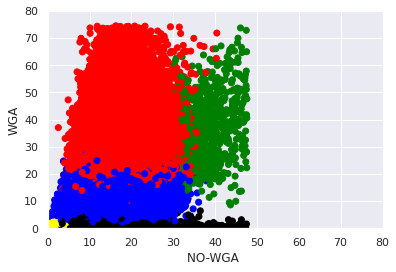

HMM labels color:  {'black': [5, 12587], 'blue': [1, 96020], 'yellow': [3, 467], 'green': [0, 1043], 'red': [2, 77675]}


In [43]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                                                                          observations=observations, 
                                                                          sequence_viterbi_state=sequence_viterbi_state, 
                       no_wga_obs=no_wga_obs, wga_obs=wga_obs)
print("HMM labels color: ", color_comp_assoc_hmm)

State:  Duplication
Length: 1043


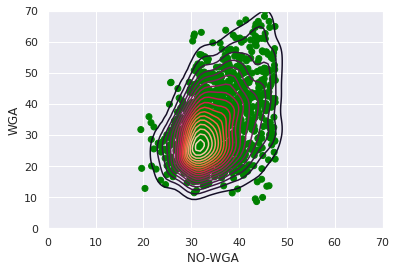

State:  Normal-I
Length: 96020


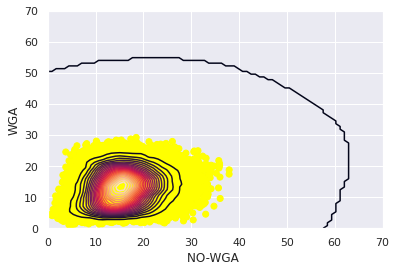

State:  Normal-II
Length: 77675


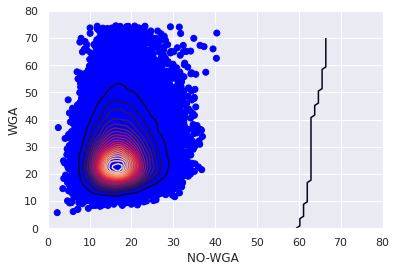

State:  Deletion
Length: 467


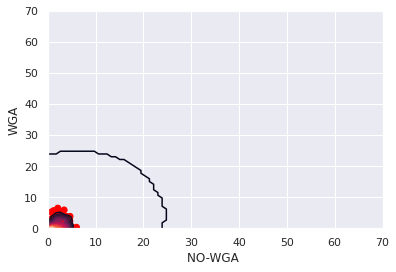

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 12587


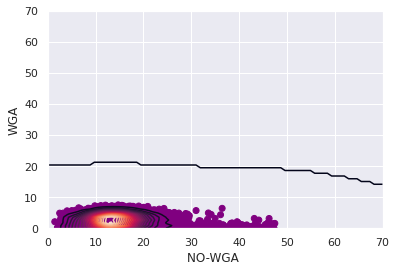

In [44]:
plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80)


#### Region with window size 200

In [142]:
region_name = "region_0_REGION_1_5S_200WS.txt"
region_file = "/home/david/Desktop/" + region_name
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/david/Desktop/region_0_REGION_1_5S_200WS.txt


In [143]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  94588


In [144]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

# for each item in the sequence
# cache the index and state predicted
sequence_viterbi_state = []

if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))
        filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name 
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                sequence_viterbi_state.append((item, viterbi_path[1][item+1][1].name))
                
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  94588
Done. Execution time 0.2796628639989649 secs
Log-probability of ML Viterbi path:  -603505.2063986211
Viterbi path length:  94589
There should be 721 gaps


In [146]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  93867
Encountered gaps:  721


In [147]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

# collect counters for error statistics
for i, obs in enumerate(observations):
    
    # what dows the Viterbi path says
    viterbi_state = sequence_viterbi_state[i][1]
    if obs == (-999.0, -999.0):
        
        # if we predict that increase the success 
        # otherwise increase errors
        if viterbi_state == 'GAP_STATE':
            states_counter[viterbi_state] += 1
        else:
            states_counter["GAP_STATE_INCORRECT"] += 1
    else:
        states_counter[viterbi_state] += 1   
        
print(states_counter)

{'Duplication': 491, 'Normal-I': 47798, 'Normal-II': 39244, 'Deletion': 168, 'Single-Deletion': 0, 'TUF': 6166, 'GAP_STATE': 721, 'GAP_STATE_INCORRECT': 0}


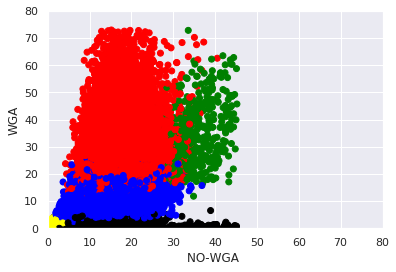

HMM labels color:  {'black': [5, 6166], 'blue': [1, 47798], 'yellow': [3, 168], 'green': [0, 491], 'red': [2, 39244]}


In [148]:
hmm_labels = []
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

# collect the labels as these are predicted by the HMM
for i, obs in enumerate(observations):
        
        # do not account for GAPs
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            hmm_labels.append(hmm_states_to_labels[viterbi_state])


colors = np.array(['green', 'blue', 'red', 'yellow', 'pink', 'black'])
colors = colors[hmm_labels]
       
plt.scatter(no_wga_obs, wga_obs,  color=colors)
                
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(0.0, 80.0)
plt.ylim(0.0, 80.0)
plt.show()

color_comp_assoc_hmm = {}
for label, color in zip(hmm_labels, colors):
    if color in color_comp_assoc_hmm.keys():
        assert color_comp_assoc_hmm[color][0] == label
        color_comp_assoc_hmm[color][1] += 1
    else:
        color_comp_assoc_hmm[color] = [label, 1]
        
print("HMM labels color: ", color_comp_assoc_hmm)